In [3]:
from PIL import Image
import requests
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

In [4]:
#torch.cuda.get_device_properties(0).total_memory

#### Load model

In [5]:
# model_name
model_name = "Qwen/Qwen2-VL-2B-Instruct"

# load model
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
     torch_dtype=torch.bfloat16,
     attn_implementation="flash_attention_2",
     device_map="auto",
)
model.eval()

# load processor
processor = AutoProcessor.from_pretrained(model_name)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
model.visual

Qwen2VisionTransformerPretrainedModel(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
  )
  (rotary_pos_emb): VisionRotaryEmbedding()
  (blocks): ModuleList(
    (0-31): 32 x Qwen2VLVisionBlock(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): VisionFlashAttention2(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (mlp): VisionMlp(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): QuickGELUActivation()
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      )
    )
  )
  (merger): PatchMerger(
    (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=5120, out_features=5120, bias=True)
      (1): G

In [24]:
model.config

Qwen2VLConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2-VL-2B-Instruct",
  "architectures": [
    "Qwen2VLForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "image_token_id": 151655,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "max_position_embeddings": 32768,
  "max_window_layers": 28,
  "model_type": "qwen2_vl",
  "num_attention_heads": 12,
  "num_hidden_layers": 28,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": {
    "mrope_section": [
      16,
      24,
      24
    ],
    "rope_type": "default",
    "type": "default"
  },
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.47.1",
  "use_cache": true,
  "use_sliding_window": false,
  "video_token_id": 151656,
  "vision_config": {
    "hidden_size": 1536,
    "in_c

In [13]:
model.config.vision_config

Qwen2VLVisionConfig {
  "depth": 32,
  "embed_dim": 1280,
  "hidden_act": "quick_gelu",
  "hidden_size": 1536,
  "in_channels": 3,
  "in_chans": 3,
  "mlp_ratio": 4,
  "model_type": "qwen2_vl",
  "num_heads": 16,
  "patch_size": 14,
  "spatial_merge_size": 2,
  "spatial_patch_size": 14,
  "temporal_patch_size": 2,
  "transformers_version": "4.47.1"
}

#### Image

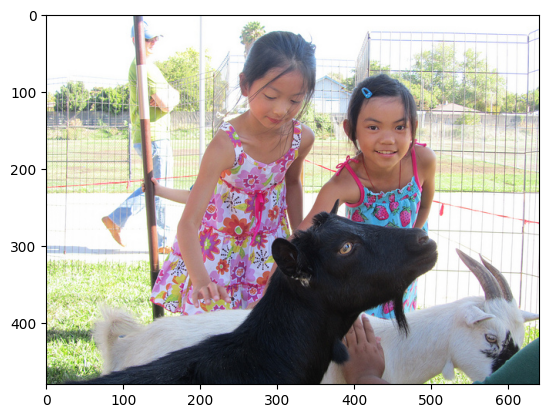

In [6]:
image = Image.open("/home/drdo/vlm-compositionality/data/raw/coco_val_2017/000000008690.jpg")
plt.imshow(image)

#### Process image

In [8]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [10]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])

In [12]:
inputs['input_ids'].shape

torch.Size([1, 416])

In [14]:
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['The image depicts two young girls standing next to two goats in an outdoor setting. The girl on the left is wearing a pink and white floral dress with a pink bow, while the girl on the right is wearing a blue and pink dress with a pink bow. Both girls are smiling and appear to be enjoying their time with the goats.\n\nThe goats are positioned in the foreground of the image, with one goat being black and the other white. The black goat is lying down, and the white goat is standing nearby. The background shows a fenced area, possibly a pen or enclosure, with some trees and a building visible in the distance. The']


#### Forward pass

In [30]:
## llava ##

# 32+1 layers
# each layer hidden_state -> b x seq_len x embed_dim [ignoring b = 1]

# model.vision_tower = CLIPVisionModel
# model.config.vision_feature_layer = -2

# pixel_values : torch.Size([1, 3, 336, 336])
# patch_embeds: torch.Size([1, 1024, 24, 24])
# patch_embeds flattened : torch.Size([1, 576, 1024])
# embeddings : torch.Size([1, 577, 1024])
# hidden_states : torch.Size([1, 577, 1024])
# hidden_states output -2 layer : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 576, 1024])
# image_features : torch.Size([1, 576, 4096])

In [15]:
output = model(**inputs, output_hidden_states=True)

In [20]:
inputs['pixel_values'].shape

torch.Size([1564, 1176])

In [27]:
torch.count_nonzero((inputs['input_ids'] == model.config.image_token_id).long())

tensor(391, device='cuda:0')

In [17]:
output.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states', 'rope_deltas'])

In [30]:
output['hidden_states'][0].shape

torch.Size([1, 416, 1536])

#### Get softmax scores for layer

In [79]:
image_indices = torch.nonzero((inputs['input_ids'][0] == model.config.image_token_index).long())
image_indices = image_indices.flatten()
reps = torch.vstack(output['hidden_states'])    # 33, 593, 4096

In [80]:
image_reps = torch.index_select(reps, 1, image_indices)
#image_reps = torch.rand(33, 576, 4096).to(torch.bfloat16)

unembed_matrix = model.language_model.lm_head
unembedded_image_reps = unembed_matrix(image_reps)

# scores for all layers
scores = F.softmax(unembedded_image_reps, dim=1)

In [81]:
scores.shape

torch.Size([33, 576, 32064])

#### Get max tokens

In [60]:
max_tokens = torch.argmax(scores, dim=2)
#processor.tokenizer.decode(max_tokens)

In [61]:
max_tokens.shape

torch.Size([33, 576])

#### Map embeddings to image patches

In [ ]:
# How to map patch_embeds to pixel_values?

In [82]:
def internal_confidence_heatmap(tokenizer, scores, object):
    class_token_indices = tokenizer.encode(object)[1:]
    if len(class_token_indices) > 1:
        heatmap = 0
        for index in class_token_indices:
            heatmap += scores[:, :, index]
        return heatmap.T
    else:
        return torch.squeeze(scores[:, :, class_token_indices], dim=2).T

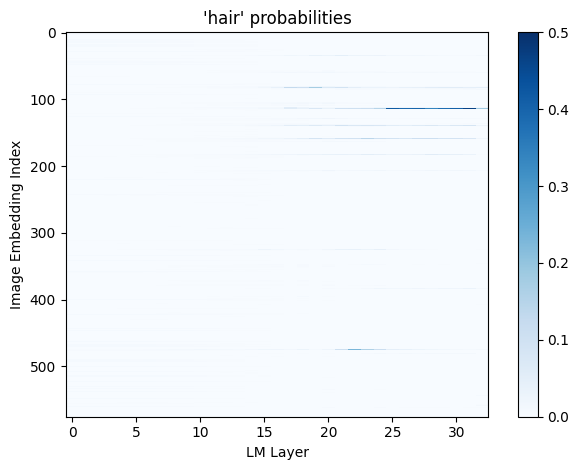

In [89]:
#object = 'tree'
#object = 'car'
#object = 'signs'
#object = 'red'
#object = 'stop'
#object = 'gate'
#object = 'leaves'

# 000000002592.jpg
#object = 'knife'
#object = 'mug'

# 000000008690.jpg
#object = 'goat'
#object = 'girl'
object = 'hair'

heatmap_data = internal_confidence_heatmap(processor.tokenizer, scores, object).detach().cpu().float()
num_image_embeddings = scores.shape[1]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{object}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 0.5)   # 0, 1
plt.colorbar()
plt.show()

In [90]:
def internal_confidence_segmentation(tokenizer, scores, object, num_patches=24):
    class_token_indices = tokenizer.encode(object)[1:]

    if len(class_token_indices) > 1:
        obj_scores = 0
        for index in class_token_indices:
            obj_scores += scores[:, :, index]
    
    else:
        obj_scores = torch.squeeze(scores[:, :, class_token_indices], dim = 2)
        
    max_obj_scores = torch.max(obj_scores, dim=0).values.reshape(num_patches, num_patches).float()
    return max_obj_scores

/tmp/ipykernel_1040/777978903.py:4: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  segmentation_resized = (np.array(Image.fromarray(segmentation.detach().cpu().numpy()).resize((img_width, img_height), Image.BILINEAR)))


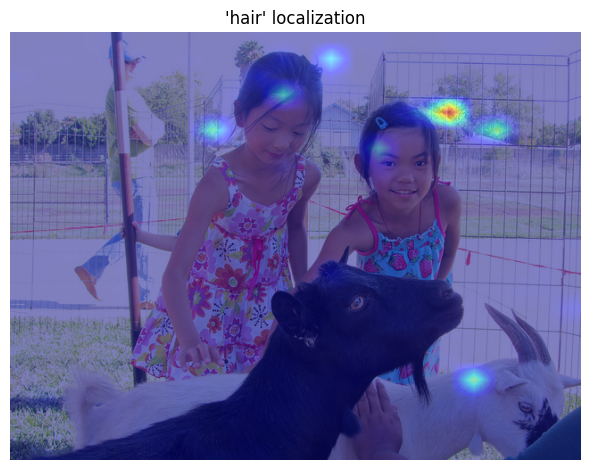

In [91]:
img_width, img_height = image.size

segmentation = internal_confidence_segmentation(processor.tokenizer, scores, object, num_patches=24)
segmentation_resized = (np.array(Image.fromarray(segmentation.detach().cpu().numpy()).resize((img_width, img_height), Image.BILINEAR)))

plt.imshow(image)
plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=0.5)
plt.axis('off')
plt.title(f"'{object}' localization")
plt.tight_layout()
plt.show()